In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Computed Mean: 0.0004784451271776364, Std: 0.04881008519405821
Data Augmented


<ipython-input-2-40acb963b9fe>:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/epoch30/pytorch/default/1/resnet15_weights.

Model Created
Epoch 1, Loss: 0.5397
Epoch 2, Loss: 0.5390
Epoch 3, Loss: 0.5382
Epoch 4, Loss: 0.5371
Epoch 5, Loss: 0.5369
Epoch 6, Loss: 0.5363
Epoch 7, Loss: 0.5361
Epoch 8, Loss: 0.5353
Epoch 9, Loss: 0.5348
Epoch 10, Loss: 0.5347
Epoch 11, Loss: 0.5340
Epoch 12, Loss: 0.5337
Epoch 13, Loss: 0.5330
Epoch 14, Loss: 0.5329
Epoch 15, Loss: 0.5321
Epoch 16, Loss: 0.5321
Epoch 17, Loss: 0.5316
Epoch 18, Loss: 0.5310
Epoch 19, Loss: 0.5307
Epoch 20, Loss: 0.5307
Epoch 21, Loss: 0.5302
Epoch 22, Loss: 0.5299
Epoch 23, Loss: 0.5297
Epoch 24, Loss: 0.5292
Epoch 25, Loss: 0.5289
Epoch 26, Loss: 0.5290
Epoch 27, Loss: 0.5288
Epoch 28, Loss: 0.5282
Epoch 29, Loss: 0.5285
Epoch 30, Loss: 0.5278
Epoch 31, Loss: 0.5271
Epoch 32, Loss: 0.5271
Epoch 33, Loss: 0.5267
Epoch 34, Loss: 0.5266
Epoch 35, Loss: 0.5263
Epoch 36, Loss: 0.5257
Epoch 37, Loss: 0.5262
Epoch 38, Loss: 0.5255
Epoch 39, Loss: 0.5252
Epoch 40, Loss: 0.5247
Training Finished


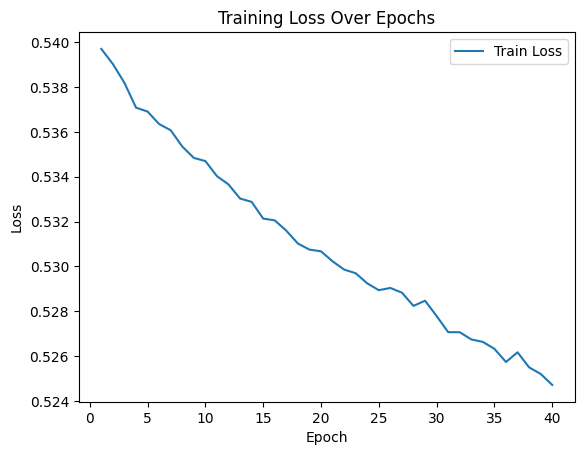

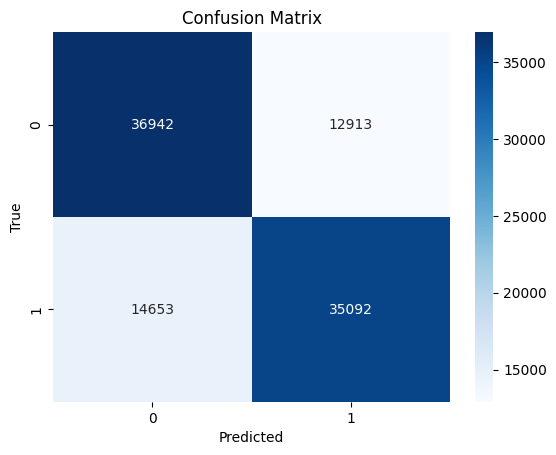

Accuracy: 72.32%


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import h5py
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Dataset Class
class ParticleDataset(Dataset):
    def __init__(self, hdf5_files, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        
        for idx, file in enumerate(hdf5_files):
            with h5py.File(file, 'r') as f:
                X = f['X'][:]
                y = np.full((X.shape[0],), idx)  # Assign label 0 for electrons, 1 for photons
                self.data.append(X)
                self.labels.append(y)
        
        self.data = np.concatenate(self.data, axis=0)
        self.labels = np.concatenate(self.labels, axis=0)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Load Dataset
full_dataset = ParticleDataset(['/kaggle/input/cms-particle-collison/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 
                                '/kaggle/input/cms-particle-collison/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'])

# Split into Train and Test  # **MODIFIED**
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Compute Mean and Std for Normalization on Train Set  # **MODIFIED**
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    mean = 0.0
    std = 0.0
    total_samples = 0
    for images, _ in loader:
        batch_samples = images.size(0)  # Batch size
        images = images.view(batch_samples, -1)
        mean += images.mean(dim=1).sum().item()
        std += images.std(dim=1).sum().item()
        total_samples += batch_samples
    mean /= total_samples
    std /= total_samples
    return mean, std

mean, std = compute_mean_std(train_dataset)  # **MODIFIED**
print(f"Computed Mean: {mean}, Std: {std}")

# Define Data Augmentation and Normalization  # **MODIFIED**
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((mean,), (std,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# Reload dataset with transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data Augmented")

# Define ResNet-like Model
class ResNet15(nn.Module):
    def __init__(self):
        super(ResNet15, self).__init__()
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.res_layers = self._make_res_layers(64, 128, 4)
        # Compute final feature map size dynamically
        with torch.no_grad():
            dummy_input = torch.randn(1, 2, 32, 32)
            dummy_output = self.res_layers(self.relu(self.bn1(self.conv1(dummy_input))))
            final_h, final_w = dummy_output.shape[2], dummy_output.shape[3]
        
        self.fc = nn.Linear(128 * final_h * final_w, 2)
    
    def _make_res_layers(self, in_channels, out_channels, blocks):
        layers = []
        for _ in range(blocks):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.res_layers(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet15().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
model.load_state_dict(torch.load("/kaggle/input/epoch30/pytorch/default/1/resnet15_weights.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Created")

# Training Loop
num_epochs = 40
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

print("Training Finished")

# Plot Training Loss
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Evaluation
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true):.2f}%')



torch.save(model.state_dict(), "resnet15_weights.pth")

In [3]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision.transforms as transforms
# import h5py
# import numpy as np
# import matplotlib.pyplot as plt
# from torch.utils.data import Dataset, DataLoader, random_split

# # Custom Dataset Class
# class ParticleDataset(Dataset):
#     def __init__(self, hdf5_files, transform=None):
#         self.data = []
#         self.labels = []
#         self.transform = transform
        
#         for idx, file in enumerate(hdf5_files):
#             with h5py.File(file, 'r') as f:
#                 X = f['X'][:]
#                 y = np.full((X.shape[0],), idx)  # Assign label 0 for electrons, 1 for photons
#                 self.data.append(X)
#                 self.labels.append(y)
        
#         self.data = np.concatenate(self.data, axis=0)
#         self.labels = np.concatenate(self.labels, axis=0)
    
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         img = self.data[idx]
#         label = self.labels[idx]
        
#         if self.transform:
#             img = self.transform(img)
        
#         return img, label

# # Load Dataset
# full_dataset = ParticleDataset(['/kaggle/input/cms-particle-collison/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 
#                                 '/kaggle/input/cms-particle-collison/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'])

# # Split into Train and Test
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# # Compute Mean and Std for Normalization on Train Set
# def compute_mean_std(dataset):
#     loader = DataLoader(dataset, batch_size=32, shuffle=False)
#     mean = 0.0
#     std = 0.0
#     total_samples = 0
#     for images, _ in loader:
#         batch_samples = images.size(0)  # Batch size
#         images = images.view(batch_samples, -1)
#         mean += images.mean(dim=1).sum().item()
#         std += images.std(dim=1).sum().item()
#         total_samples += batch_samples
#     mean /= total_samples
#     std /= total_samples
#     return mean, std

# mean, std = compute_mean_std(train_dataset)
# print(f"Computed Mean: {mean}, Std: {std}")

# # Define Data Augmentation and Normalization
# train_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
#     transforms.Normalize((mean,), (std,))
# ])

# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((mean,), (std,))
# ])

# # # Reload dataset with transforms
# train_dataset.dataset.transform = train_transform
# test_dataset.dataset.transform = test_transform

# # Data Loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# print("Data Augmented")

# # Define Improved ResNet-15 Model
# class ResNet15Enhanced(nn.Module):
#     def __init__(self):
#         super(ResNet15Enhanced, self).__init__()
#         self.conv1 = nn.Conv2d(2, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.res_layers = self._make_res_layers(64, 128, 4)
#         self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.dropout = nn.Dropout(0.3)
#         self.fc = nn.Linear(128, 2)
    
#     def _make_res_layers(self, in_channels, out_channels, blocks):
#         layers = []
#         for _ in range(blocks):
#             layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
#             layers.append(nn.BatchNorm2d(out_channels))
#             layers.append(nn.ReLU(inplace=True))
#             in_channels = out_channels
#         return nn.Sequential(*layers)
    
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.res_layers(x)
#         x = self.global_avg_pool(x)
#         x = torch.flatten(x, start_dim=1)
#         x = self.dropout(x)
#         x = self.fc(x)
#         return x

# # Training Setup
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ResNet15Enhanced().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# print("Model Created")

# # Training Loop
# num_epochs = 30
# train_losses = []
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#     scheduler.step()
#     epoch_loss = running_loss / len(train_loader)
#     train_losses.append(epoch_loss)
#     print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

# print("Training Finished")

# # Evaluation
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy: {100 * correct / total:.2f}%')

# torch.save(model.state_dict(), "resnet15_weights.pth")